In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import seaborn as sns; sns.set_style("darkgrid") # styling

In [3]:
def createSubplot(n):
    fig,axs = plt.subplots(n,figsize=(15,8))
    fig.tight_layout(pad=3.0)
    return fig,axs

In [4]:
### Calculte FFT
def next_pow2(x):
    return 1<<(x-1).bit_length()

### FFT with zero-padding
def calculate_FFT(time,inputSignal, n_zeropad=0, window="False", timescaling=1):
    
    my_signal = inputSignal.copy()
    if window != "False":
        window = get_window(window, time.shape[0])
        my_signal *= window # multiply signal by window to reduce fluctuation in frequency-domain
    
    
    zero_padding = np.zeros(int(n_zeropad))
    time_zeropadding = np.hstack((time,zero_padding))          # zero-padding in time-domain
    
    nfft = time_zeropadding.shape[0]           # get the number of samples in the signal
#     nfft = next_pow2(nfft)                                     # FFT is more efficient when using number of samples is part of power of 2
    fft = np.fft.fft(my_signal,nfft)[:int(np.ceil(nfft/2))]             # extract only the 1st half of the result (one-side frequency
    fft = fft*2                                                # multiply magnitude by 2 after select only one-side frequency
    corr_mag_fft = np.abs(fft)/nfft * time_zeropadding.shape[0]/time.shape[0] / timescaling

    df = fs/nfft                                   # finding frequency resolution
    xfft = np.arange(0, fs/2,df)                   # correcting x-axis
    xfft = xfft / (fs/2)                               # Normalized x-axis
    return xfft, corr_mag_fft

### Filtering concept
- cut off freq.
- order
- zero-pole
- Normalized frequency
- butter worm
- cheby 1
- cheby 2


### Noise is Gaussian noise(Mean, Variance)

Text(0.5, 1.0, 'Frequency-domain')

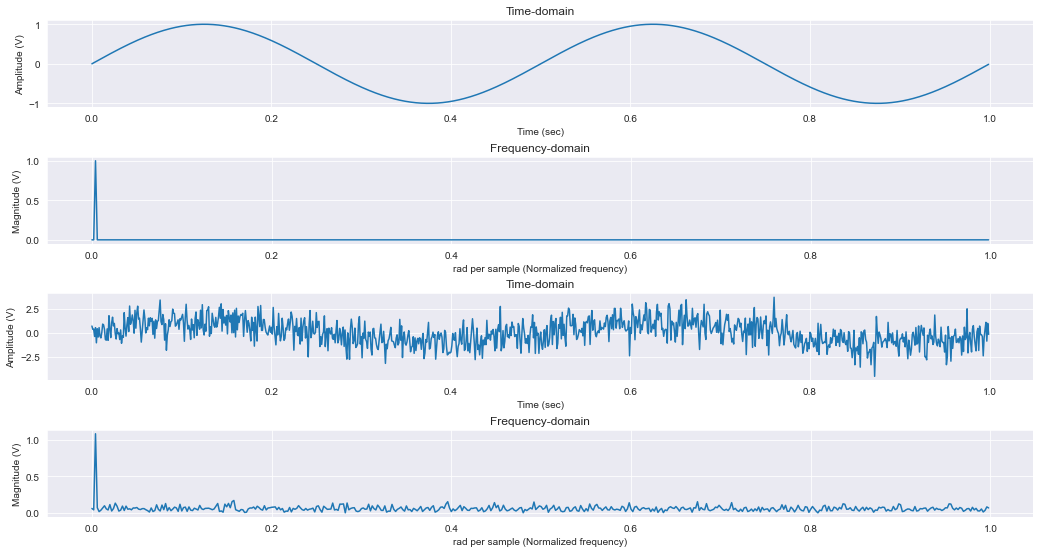

In [5]:
f0 = 2
fs = 1000
dt = 1/fs
startTime = 0
stopTime = 1
time = np.arange(startTime,stopTime,dt)
signal_001 = np.sin(2*np.pi*f0*time)
signal_000 = signal_001 + np.random.normal(loc=0,scale=1,size=fs)

# Prepare subplots
fig, axs = createSubplot(4)

# sine signal (Time, Freq. domain)
# sine+noise signal (Time, Freq. domain(normalize Amp. and Freq.(x-axis: rad per sample (Normalized frequency))))
plt.sca(axs[0])
plt.plot(time, signal_001)
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude (V)")
plt.title("Time-domain")

xfft_001, corr_mag_fft_001 = calculate_FFT(time, signal_001)
plt.sca(axs[1])
plt.plot(xfft_001, corr_mag_fft_001)
plt.xlabel("rad per sample (Normalized frequency)")
plt.ylabel("Magnitude (V)")
plt.title("Frequency-domain")

plt.sca(axs[2])
plt.plot(time, signal_000)
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude (V)")
plt.title("Time-domain")

plt.sca(axs[3])
xfft_000, corr_mag_fft_000 = calculate_FFT(time, signal_000)
plt.plot(xfft_000, corr_mag_fft_000)
plt.xlabel("rad per sample (Normalized frequency)")
plt.ylabel("Magnitude (V)")
plt.title("Frequency-domain")

### Do not forget to normalized Amp. and Freq. axis
- linearly scale ???? 
- 0.5 db 
    - lin = 20log10(-0.5) = 0.94

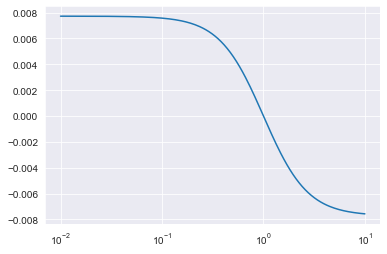

In [6]:
b, a = signal.butter(2, 0.2, 'hp', fs=1000, output='ba')
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))

### Noise is sine wave with 100 Hz

lowpass


NameError: name 'mode' is not defined

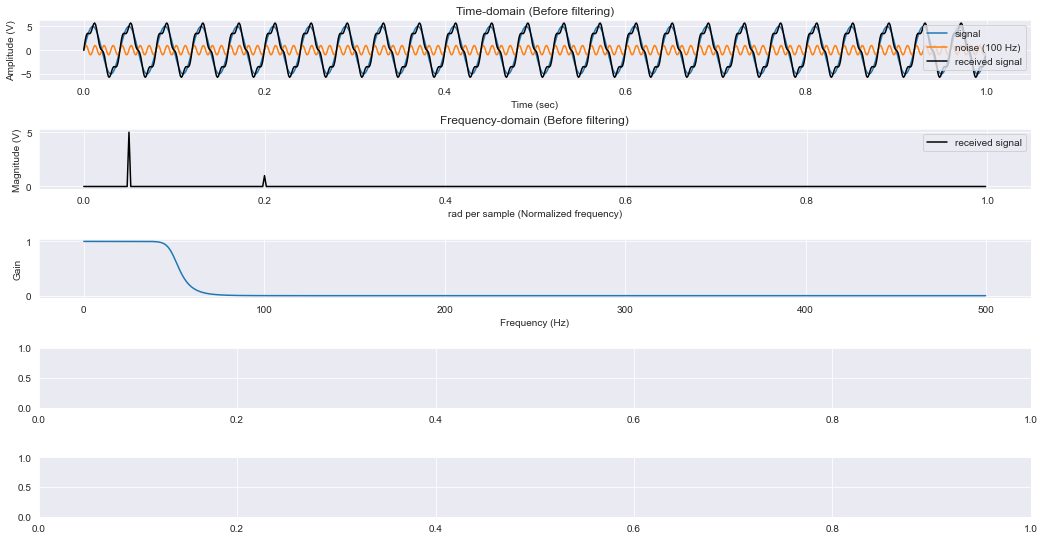

In [9]:
f0 = 25
fs = 1000
dt = 1/fs
startTime = 0
stopTime = 1
time = np.arange(startTime,stopTime,dt)
signal_001 = 5*np.sin(2*np.pi*f0*time) # Desired signal
signal_noise = np.sin(2*np.pi*100*time) # Noise
signal_000 = signal_001 + signal_noise # received signal

# Prepare subplots
fig, axs = createSubplot(5)

# sine signal (Time, Freq. domain)
# sine+noise signal (Time, Freq. domain(normalize Amp. and Freq.(x-axis: rad per sample (Normalized frequency))))
plt.sca(axs[0])
plt.plot(time, signal_001, label="signal")
plt.plot(time, signal_noise, label="noise (100 Hz)")
plt.plot(time, signal_000, color="k",label="received signal")
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude (V)")
plt.title("Time-domain (Before filtering)")
plt.legend(loc="upper right")

xfft_000, corr_mag_fft_000 = calculate_FFT(time, signal_000)
plt.sca(axs[1])
plt.plot(xfft_000, corr_mag_fft_000, color="k", label="received signal")
plt.xlabel("rad per sample (Normalized frequency)")
plt.ylabel("Magnitude (V)")
plt.title("Frequency-domain (Before filtering)")
plt.legend(loc="upper right")

order = 10
plt.sca(axs[2])
b, a = butter_filter(lowcut=50, highcut=0, fs=fs, mode="lowpass",order=order)
w, h = signal.freqz(b, a, worN=2000)
plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title(f"Butterworth filter: {mode}")
plt.legend(loc='best')

signal_000_filtered = signal.lfilter(b, a, signal_000)
plt.sca(axs[3])
plt.plot(time, signal_000_filtered, color="k", label="filtered signal")
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude (V)")
plt.title("Time-domain (After filtering)")
plt.legend(loc="upper right")

xfft_000, corr_mag_fft_000 = calculate_FFT(time, signal_000_filtered)
plt.sca(axs[4])
plt.plot(xfft_000, corr_mag_fft_000, color="k", label="filtered signal")
plt.xlabel("rad per sample (Normalized frequency)")
plt.ylabel("Magnitude (V)")
plt.title("Frequency-domain (After filtering)")
plt.legend(loc="upper right")

In [8]:
def butter_filter(lowcut=0, highcut=0, fs=10000, mode="bandpass", order=5):
    nyq = 0.5 * fs
#     low = lowcut / nyq
#     high = highcut / nyq
    low = lowcut
    if mode == "lowpass":
        Wh = low
    elif mode == "highpass":
        Wh = high
    elif mode in ["bandpass", "bandstop"]:
        Wh = [low, high]
    print(mode)
    b, a = signal.butter(order, Wh, btype=mode,fs=fs)
    return b, a

bandpass
bandpass
bandpass
bandpass


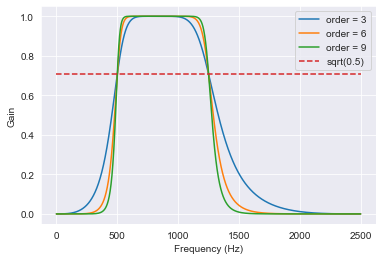

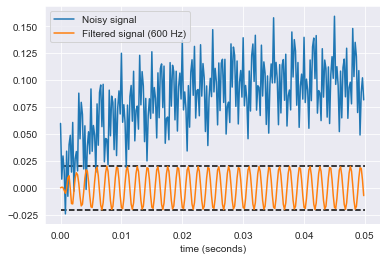

In [67]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = 5000.0
lowcut = 500.0
highcut = 1250.0
mode = "bandpass"
# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()

for order in [3, 6, 9]:
    b, a = butter_filter(lowcut, highcut, fs, mode=mode,order=order)
    w, h = signal.freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')



# Filter a noisy signal.
T = 0.05
nsamples = int(T * fs)
t = np.linspace(0, T, nsamples, endpoint=False)
amp = 0.02
f0 = 600.0
x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
x += amp * np.cos(2 * np.pi * f0 * t + .11)
x += 0.03 * np.cos(2 * np.pi * 2000 * t)
plt.figure(2)
plt.clf()
plt.plot(t, x, label='Noisy signal')

b, a = butter_filter(lowcut, highcut, fs, mode=mode,order=6)
y = signal.lfilter(b, a, x)

plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
plt.xlabel('time (seconds)')
plt.hlines([-amp, amp], 0, T, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

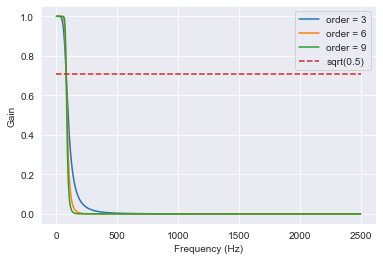

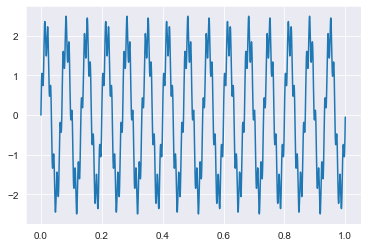

In [88]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = 5000.0
lowcut = 80.0
highcut = 1250.0
mode = "lowpass"
# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()

for order in [3, 6, 9]:
    b, a = butter_filter(lowcut, highcut, fs, mode=mode,order=order)
    w, h = signal.freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')



# Filter a noisy signal.
fs = 10000.0
dt = 1/fs
t = np.arange(0,1, dt)
f0 = 1
x = 2 * np.sin(2 * np.pi * 15 * t)
x += 0.5*np.sin(2 * np.pi * 100 * t)
plt.figure(2)
plt.clf()
plt.plot(t, x, label='Noisy signal')
plt.show()

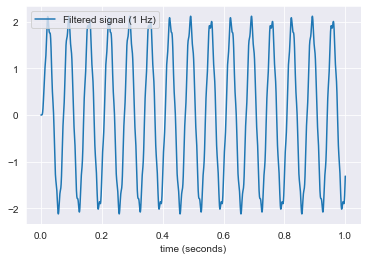

In [89]:
b, a = butter_filter(lowcut, highcut, fs, mode=mode,order=6)
y = signal.lfilter(b, a, x)

plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

In [ ]:
ripple_db = 0.8
b, a = signal.cheby1(4, ripple_db, 100, 'low', analog=True)

In [ ]:
b, a = signal.ellip(4, 5, 40, 100, 'low', analog=True)

### Plot of butterworth, chebyshev, elliptical

### Change from low-pass filter to band-pass filter

### Change from low-pass filter to band-reject filter

### Homework

1) Describe in Brief the following filters

    - Butter worth
    - Chephyshev Type 1
    - Chephyshev Type 2
    - Elliptie
    
2) Plot the frequency response of the above ilters
    - Equiripple Amplitude characteristic of Chephyshev Type 1
    
3) Demonstrate the use of above filters in removing noise from signal

### 2) Plot the frequency response of the above ilters

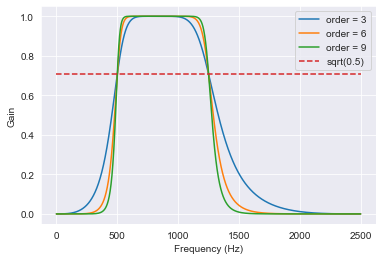

In [100]:
def butter_filter(lowcut, highcut, fs, mode, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if mode == "lowpass":
        Wh = low
    elif mode == "highpass":
        Wh = high
    elif mode in ["bandpass", "bandstop"]:
        Wh = [low, high]
    b, a = signal.butter(order, Wh, btype=mode)
    return b, a

# Sample rate and desired cutoff frequencies (in Hz).
fs = 5000.0
lowcut = 500.0
highcut = 1250.0

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()

for order in [3, 6, 9]:
    b, a = butter_filter(lowcut, highcut, fs, mode="bandpass",order=order)
    w, h = signal.freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

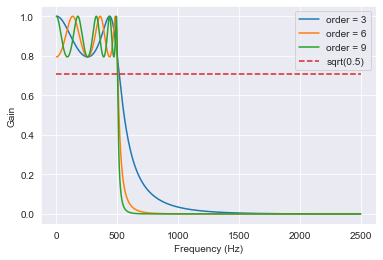

In [111]:
def cheby1_filter(lowcut, highcut, fs, mode, rp=1,order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if mode == "lowpass":
        Wh = low
    elif mode == "highpass":
        Wh = high
    elif mode in ["bandpass", "bandstop"]:
        Wh = [low, high]
    b, a = signal.cheby1(order, rp,Wh, btype=mode)
    return b, a

# Sample rate and desired cutoff frequencies (in Hz).
fs = 5000.0
lowcut = 500.0
highcut = 1250.0
rp = 2 # maximum ripple

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()

for order in [3, 6, 9]:
    b, a = cheby1_filter(lowcut, highcut, fs, mode="lowpass", rp=rp, order=order)
    w, h = signal.freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

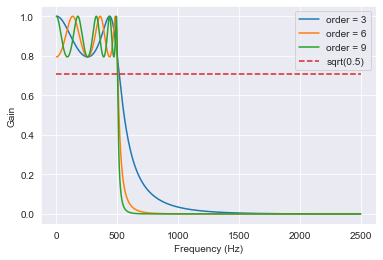

In [141]:
def cheby1_filter(lowcut, highcut, fs, mode, rp=1,order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if mode == "lowpass":
        Wh = low
    elif mode == "highpass":
        Wh = high
    elif mode in ["bandpass", "bandstop"]:
        Wh = [low, high]
    b, a = signal.cheby1(order, rp,Wh, btype=mode)
    return b, a

# Sample rate and desired cutoff frequencies (in Hz).
fs = 5000.0
lowcut = 500.0
highcut = 1250.0
rp = 2 # maximum ripple

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()

for order in [3, 6, 9]:
    b, a = cheby1_filter(lowcut, highcut, fs, mode="lowpass", rp=rp, order=order)
    w, h = signal.freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

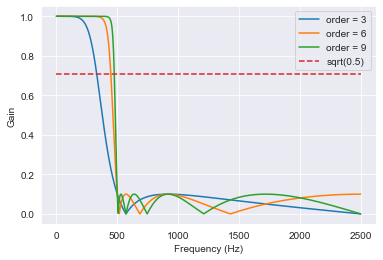

In [163]:
def cheby2_filter(lowcut, highcut, fs, mode, rs=1,order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if mode == "lowpass":
        Wh = low
    elif mode == "highpass":
        Wh = high
    elif mode in ["bandpass", "bandstop"]:
        Wh = [low, high]
    b, a = signal.cheby2(order, rs,Wh, btype=mode)
    return b, a

# Sample rate and desired cutoff frequencies (in Hz).
fs = 5000.0
lowcut = 500.0
highcut = 1250.0
rs = 20 # maximum ripple

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()

for order in [3, 6, 9]:
    b, a = cheby2_filter(lowcut, highcut, fs, mode="lowpass", rs=rs, order=order)
    w, h = signal.freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

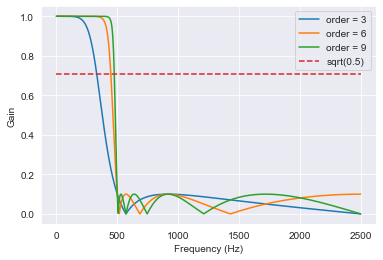

In [161]:
def cheby2_filter(lowcut, highcut, fs, mode, rs=1,order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if mode == "lowpass":
        Wh = low
    elif mode == "highpass":
        Wh = high
    elif mode in ["bandpass", "bandstop"]:
        Wh = [low, high]
    b, a = signal.cheby2(order, rs, Wh, btype=mode)
    return b, a

# Sample rate and desired cutoff frequencies (in Hz).
fs = 5000.0
lowcut = 500.0
highcut = 1250.0
rs = 20 # minimum ripple

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()

for order in [3, 6, 9]:
    b, a = cheby2_filter(lowcut, highcut, fs, mode="lowpass", rs=rs, order=order)
    w, h = signal.freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

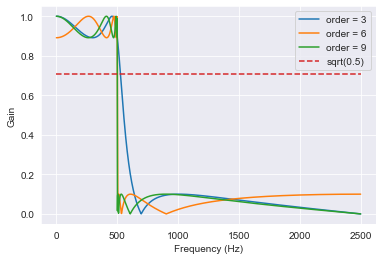

In [164]:
def ellip_filter(lowcut, highcut, fs, mode, rp=1, rs=1,order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if mode == "lowpass":
        Wh = low
    elif mode == "highpass":
        Wh = high
    elif mode in ["bandpass", "bandstop"]:
        Wh = [low, high]
    b, a = signal.ellip(order, rp, rs, Wh, btype=mode)
    return b, a

# Sample rate and desired cutoff frequencies (in Hz).
fs = 5000.0
lowcut = 500.0
highcut = 1250.0
rp = 1
rs = 20 # minimum ripple

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()

for order in [3, 6, 9]:
    b, a = ellip_filter(lowcut, highcut, fs, mode="lowpass", rs=rs, order=order)
    w, h = signal.freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')